# Naiwny klasyfikator bayesowski

ZADANIE:

Wyobraźmy sobie test na chorobę X. Testy wykrywa prawdidłowo 90% chorych, ale jeśli testowi poddaje się osoba zdrowa myli się w 30% przypadków. Choroba X dotyka średnio 10% populacji. 

Jakie jest prawdodpodobieństwo, że osoba, która poddała się testowi i otrzymała wynik pozytywny (chora), jest zdrowa?

P(A|B) = (P(B|A) * P(A)) / P(B)

P(A|B) - prawdopodobieństwo zdarzenia A (zdrowa) przy zdarzeniu B (pozytywny wynikak testu) <br>
P(B|A) - prawdopodobieństwo, że test dał pozytywny wynik jeśli osoba jest zdrowa = 0.3 <br>
P(A) - prawdopodobieństwo, że osoba jest zdrowa = 0.9<br>

P(B) - prawdopobieństwo, że test dał pozytywny wynik.

P(B) <br>

10 osób na 100 jest chorych. Spośród chorych, 9 osób otrzyma pozytwyny wynik testu. <br>
90 osób jest zdrowych. Spośród zdrowych, 27 osób otrzyma pozytywny wynik testu. <br>

36 osób otrzyma pozytywny wynik testu (będzie zaklasyfikowane jako chore)

In [1]:
0.3*0.9/0.36

0.7500000000000001

### Zdefiniowane wcześniej funkcje:

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# average:
#   None - wyniki dla każdej klasy osobno
#   'binary' - dla wybranej w `pos_label` etykiety
#   'micro' - dla całkowitej liczby TP, FN, FP
#   'macro' - nieważona średnia dla każdej klasy
#   'weighted' - ważona średnia dla każdej klasy

def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')

## Budowa modelu na danych rzeczywistych

Po pierwsze, musimy zaimportować dane. Pobierzmy sobie zatem zbiory z githuba.

In [3]:
!git clone https://github.com/matzim95/ML-datasets


fatal: destination path 'ML-datasets' already exists and is not an empty directory.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_dataset(filename, class_column, index_col=None):
    dataset = pd.read_csv(f'ML-datasets/{filename}.csv', index_col=index_col)
    dataset['class'] = dataset[class_column].astype('category').cat.codes
    classes = dataset.pop(class_column).unique()
    return dataset, classes

### Wczytanie zbioru

Glass

In [5]:
glass, glass_classes = load_dataset('glass', 'Type', 'ID')

In [6]:
print(glass_classes)

glass.head()

['building_windows_float_processed' 'building_windows_non_float_processed'
 'vehicle_windows_float_processed' 'containers' 'tableware' 'headlamps']


,refractive index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron,class
ID,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,0
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,0
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,0
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,0
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,0


### Skalowanie / standaryzacja

Skalowanie i standaryzacja to techniki stosowane w przetwarzaniu danych, szczególnie w kontekście uczenia maszynowego i analizy danych. Te techniki pomagają dostosować dane do modelu, poprawiając jego wydajność i dokładność.

Skalowanie to proces przekształcenia wartości zmiennych tak, aby mieściły się w określonym zakresie. Na przykład, technika min-max scaling przekształca dane tak, że wszystkie wartości są zawarte między 0 a 1. Skalowanie jest przydatne, gdy pracujemy z danymi, które mają bardzo różne zakresy wartości. Bez skalowania, zmienne o większych wartościach mogą dominować w modelu, mimo że niekoniecznie są one ważniejsze.

Standaryzacja to proces przekształcania danych do formy, w której mają one średnią równą zero i odchylenie standardowe równą jeden. Po standaryzacji, rozkład danych ma kształt tzw. rozkładu normalnego standardowego. Standaryzacja jest często używana, gdy dane mają różne jednostki, co mogłoby wpływać na wynik modelu.

Obie techniki są często stosowane w uczeniu maszynowym, aby poprawić dokładność modeli, szczególnie tych, które są wrażliwe na skalowanie danych, takich jak maszyny wektorów nośnych (SVM) czy algorytmy oparte na odległościach, jak k-nearest neighbors (k-NN), ale mogą też ułatwiać pracę takich modeli jak regresja czy klasyfikator naiwny Bayesa.

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
standarizer = StandardScaler()
minmax = MinMaxScaler()

Wyświetlmy sobie najpierw metryki wyliczone na zbiorze oryginalnym:

In [8]:
y = glass.pop('class')
X = glass

glass.describe()

,refractive index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


A następnie dokonajmy skalowania MinMaxScalerem(). Jak widzimy poniżej, faktycznie sprowadził nam wartości każdej z kolumn do przedziału 0-1.

In [9]:
X_minmax = X.copy()

minmax.fit(X)
X_matrix = minmax.transform(X)

X_minmax[:] = X_matrix

In [10]:
X_minmax.describe()

,refractive index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,0.316744,0.402684,0.597891,0.359784,0.507310,0.080041,0.327785,0.055570,0.111783
std,0.133313,0.122798,0.321249,0.155536,0.138312,0.105023,0.132263,0.157847,0.191056
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.235843,0.327444,0.471047,0.280374,0.441071,0.019726,0.261152,0.000000,0.000000
50%,0.286655,0.386466,0.775056,0.333333,0.532143,0.089372,0.294610,0.000000,0.000000
75%,0.351514,0.465414,0.801782,0.417445,0.585268,0.098229,0.347816,0.000000,0.196078
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Standaryzacja zaś, spowodowała, że każda z kolumn, ma średnią wartość 0.

In [11]:
X_standarize = X.copy()
standarizer = StandardScaler()

standarizer.fit(X_standarize)
X_matrix = standarizer.transform(X_standarize)

X_standarize[:] = X_matrix

In [12]:
X_standarize.describe()

,refractive index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron
count,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02
mean,-2.877034e-14,2.191393e-15,-1.328117e-16,-2.988264e-16,9.525091e-16,3.527811e-17,-3.154278e-16,-6.640586e-17,-3.735330e-17
std,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00
min,-2.381516e+00,-3.286943e+00,-1.865511e+00,-2.318616e+00,-3.676472e+00,-7.639186e-01,-2.484084e+00,-3.528768e-01,-5.864509e-01
25%,-6.082728e-01,-6.141580e-01,-3.957744e-01,-5.117560e-01,-4.800288e-01,-5.756501e-01,-5.049657e-01,-3.528768e-01,-5.864509e-01
50%,-2.262293e-01,-1.323817e-01,5.527787e-01,-1.704602e-01,1.799655e-01,8.905322e-02,-2.514132e-01,-3.528768e-01,-5.864509e-01
75%,2.614331e-01,5.120326e-01,6.361680e-01,3.715977e-01,5.649621e-01,1.735820e-01,1.518057e-01,-3.528768e-01,4.422417e-01
max,5.137232e+00,4.875637e+00,1.254639e+00,4.125851e+00,3.570524e+00,8.780145e+00,5.094318e+00,5.997210e+00,4.659881e+00


Możemy już przejść do zdefiniowania modelu i jego walidacji

### Modele na danych normalizowanych MinMaxScalerem

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_minmax, y, stratify = y, random_state = 30)

In [14]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

for classifier in [MultinomialNB(), GaussianNB(), BernoulliNB()]:

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    print_results(calculate_metrics(y_test, y_pred), classifier_id = str(classifier))



Results for MultinomialNB()
----
  Accuracy:  0.42592592592592593
  Precision: 0.31140350877192985
  Recall:    0.22928849902534112
  F1 score:  0.22145467836257313
  Mislabeled 31 out of 54


Results for GaussianNB()
----
  Accuracy:  0.2777777777777778
  Precision: 0.49313725490196075
  Recall:    0.47819200779727095
  F1 score:  0.41675020885547204
  Mislabeled 39 out of 54


Results for BernoulliNB()
----
  Accuracy:  0.46296296296296297
  Precision: 0.2871794871794872
  Recall:    0.32115009746588696
  F1 score:  0.30128205128205127
  Mislabeled 29 out of 54




C:\Users\kacpe\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kacpe\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model na zbiorze wine

In [15]:
wine, wine_classes = load_dataset('wine', 'Class')
print(wine_classes)
wine.head()

['one' 'two' 'three']


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0


In [16]:
y = wine.pop('class')
X = wine

In [17]:
X_minmax = X.copy()

minmax.fit(X)
X_matrix = minmax.transform(X)

X_minmax[:] = X_matrix

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_minmax, y, stratify = y, random_state = 30)

In [19]:
gbc = GaussianNB()
gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

print_results(calculate_metrics(y_test, y_pred))

Results for classifier
----
  Accuracy:  0.9777777777777777
  Precision: 0.9791666666666666
  Recall:    0.9814814814814815
  F1 score:  0.9797235023041475
  Mislabeled 1 out of 45




Napiszmy następnie funkcję do wyświetlenia macierzy pomyłek:

In [20]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, title=None, title_appendix = '', cmap = plt.cm.Blues):

    if title_appendix:
        title_appendix = f'({title_appendix})'

    if title is None:
        title = f'Confusion Matrix {title_appendix}'

    fig, ax = plt.subplots(figsize = (10,5))

    img = ax.imshow(cm, cmap = cmap)

    ax.figure.colorbar(img, ax = ax)

    # Określanie lokalizacji ticków
    ticks = np.arange(len(classes))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    # Ustawienie lokalizatora
    ax.xaxis.set_major_locator(ticker.FixedLocator(ticks))
    ax.yaxis.set_major_locator(ticker.FixedLocator(ticks))

    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    fmt = '.2f' if cm.dtype =='float' else 'd'

    for y, row in enumerate(cm):
        for x, cell in enumerate(row):
            ax.text(x,y, format(cell, fmt), ha ='center', color = 'white' if cell > cm.max()/2 else 'black')

    fig.tight_layout()

    # Teraz możemy bezpiecznie użyć set_xticklabels() i set_yticklabels()
    ax.set_xticklabels(classes, rotation = 90)
    ax.set_yticklabels(classes, rotation = 0)

    return ax

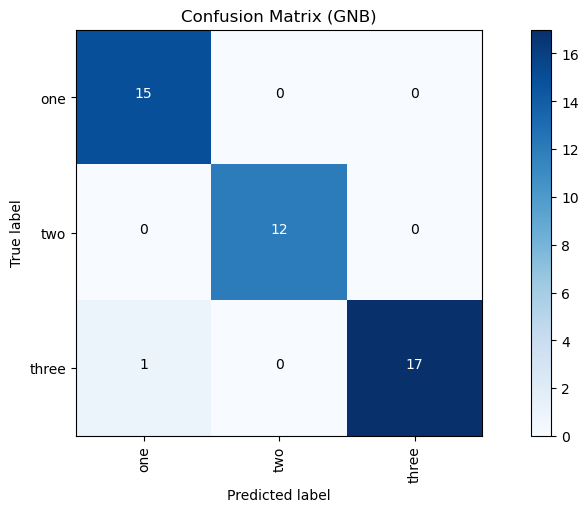

In [21]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(confusion_matrix(y_test, y_pred), wine_classes, title_appendix = 'GNB');

Dyskretyzacja:

Dyskretyzacja to proces przekształcania ciągłych zmiennych lub danych do formy dyskretnej. W kontekście przetwarzania danych i uczenia maszynowego, dyskretyzacja jest często stosowana do zmiany zmiennych ciągłych na kategorie, które mogą być łatwiej obsługiwane przez niektóre modele.

 Dyskretyzacja może być również użyta do redukcji szumów w danych, ułatwiając modelom zrozumienie i nauczenie się wzorców w danych.

In [22]:
X.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Wyświetlmy sobie najpierw rozkłady poszczególnych zmiennych:

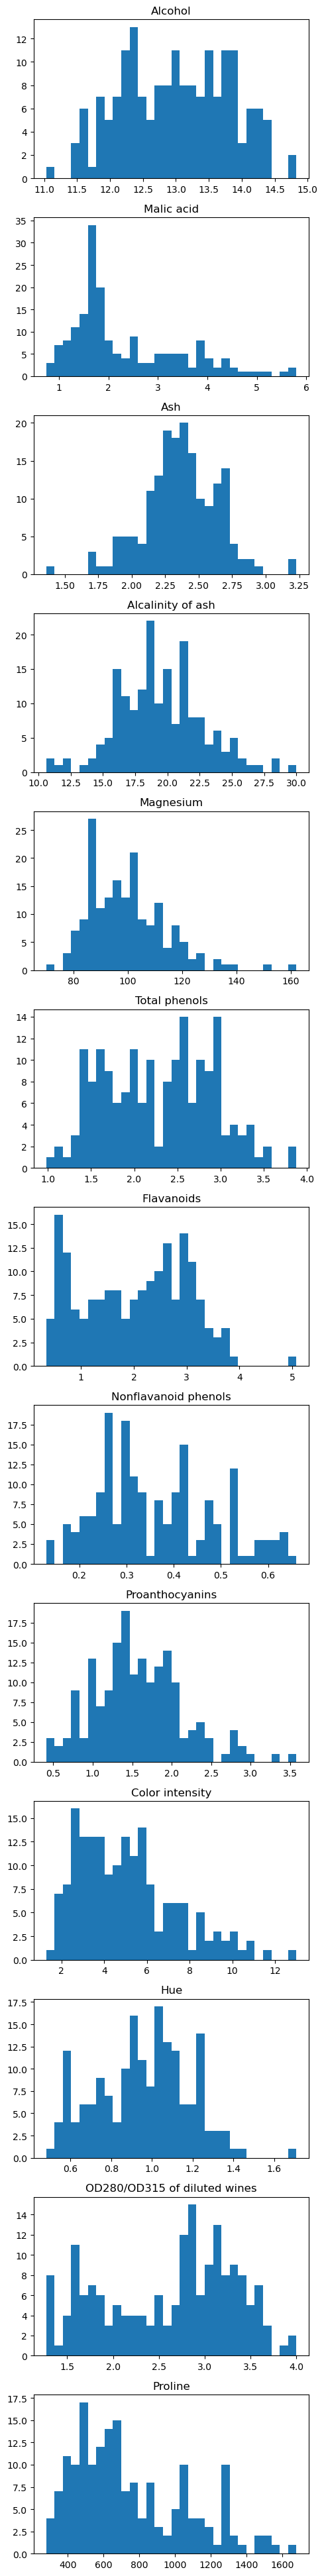

In [23]:
fig, axs = plt.subplots(len(X.columns), figsize = (5, len(X.columns)*3))

for index, column in enumerate(X):
    axs[index].hist(X[column], bins = 30)
    axs[index].set_title(column)
plt.tight_layout()
plt.show()

Zdefiniujmy sobie różne funkcje do dyskretyzacji, korzystając z pandasowych:
* pd.cut()
* pd.qcut()

Jak działa pd.cut()? 

In [24]:
pd.cut(X['Alcohol'], bins = 3).value_counts()

(12.297, 13.563]    86
(13.563, 14.83]     51
(11.026, 12.297]    41
Name: Alcohol, dtype: int64

Jak działa pd.qcut()

In [25]:
pd.qcut(X['Alcohol'], q =3).value_counts()

(11.029, 12.52]    60
(12.52, 13.48]     59
(13.48, 14.83]     59
Name: Alcohol, dtype: int64

Funkcje przeprowadzające kategoryzację:

In [26]:
def equal_lenght(column, n_bins):
    indices, bins = pd.cut(column, n_bins, retbins = True, labels = False, duplicates = 'drop')

    return indices.map(dict(enumerate(bins)))

lenght_bin = lambda x: equal_lenght(x, 5)

X_l = X.apply(lenght_bin)

In [27]:
X_l.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.07,0.73494,2.108,14.4800,125.2,2.72,2.236,0.236,1.678,3.624,0.972,3.454,838.8
1,12.55,1.75200,2.108,10.5806,88.4,2.14,2.236,0.236,1.044,3.624,0.972,2.908,838.8
2,12.55,1.75200,2.482,18.3600,88.4,2.72,3.184,0.236,2.312,3.624,0.972,2.908,1119.2
3,14.07,1.75200,2.482,14.4800,106.8,3.30,3.184,0.236,1.678,5.968,0.726,2.908,1399.6
4,12.55,1.75200,2.856,18.3600,106.8,2.72,2.236,0.342,1.678,3.624,0.972,2.908,558.4


In [28]:
def equal_frequency(column, n_bins):
    indices, bins = pd.qcut(column, n_bins, retbins = True, labels = False, duplicates = 'drop')

    return indices.map(dict(enumerate(bins)))

freq_bin = lambda x: equal_frequency(x, 5)

In [29]:
X_f = X.apply(freq_bin)

X_f.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,13.756,1.510,2.42,10.60,111.0,2.53,2.98,0.26,1.986,5.284,0.91,3.260,1048.0
1,12.760,1.730,1.36,10.60,94.8,2.53,2.46,0.13,1.104,4.080,1.04,3.260,1048.0
2,12.760,2.134,2.61,18.58,94.8,2.53,2.98,0.26,1.986,5.284,0.91,2.902,1048.0
3,13.756,1.730,2.42,10.60,111.0,2.86,2.98,0.13,1.986,6.990,0.74,3.260,1048.0
4,12.760,2.134,2.61,20.00,111.0,2.53,2.46,0.30,1.664,4.080,0.91,2.902,605.6


## Granice decyzyjne na sztucznie wygenerowanym zbiorze:

In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# losowe dane dla dwóch klas, przy przesunięciu środka rozkładu
train_data = np.vstack((np.random.normal(size=(100, 2)),
                        np.random.normal(size=(100, 2), loc=2)))

train_labels = np.hstack((np.zeros(100), np.ones(100)))


# np.vstack - połaczenie tablic wertykalne
# np.hstack - połączenie tablic horyzontalne

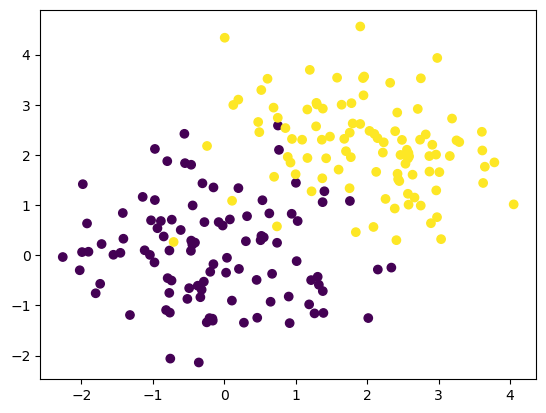

In [31]:
fig, ax = plt.subplots()

ax.scatter(train_data[:,0], train_data[:,1], c =train_labels)

In [32]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
model = GaussianNB()
model.fit(train_data, train_labels)

GaussianNB()

In [33]:
x_min, x_max = train_data[:,0].min() -1, train_data[:,0].max() +1
y_min, y_max = train_data[:,1].min() -1, train_data[:,1].max() +1

xs, ys = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

y_pred = model.predict(np.column_stack((xs.flatten(),
                                       ys.flatten())))

In [34]:
y_pred_matrix = y_pred.reshape(xs.shape)

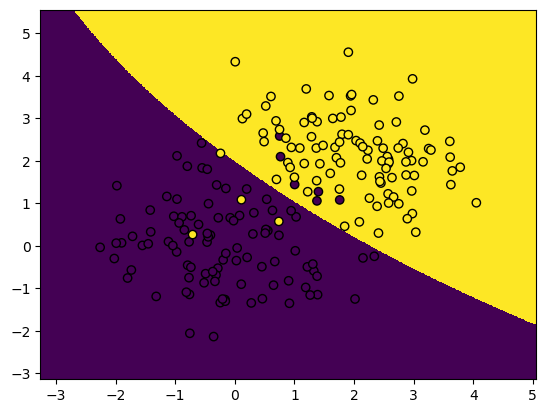

In [35]:
fig, ax = plt.subplots()
ax.pcolormesh(xs, ys, y_pred_matrix)
ax.scatter(train_data[:,0], train_data[:,1], c=train_labels, edgecolors = 'k')
plt.show()